# Exclusive $\tau^+ \to \mu^+ \mu^+ \mu^-$ mass peak reconstruction

In [34]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_type = "p8_ee_Ztautau_ecm91_EvtGen_Tau2MuMuMu"

#Load 1 sub-file of 100k events
file = uproot.open(f"/eos/experiment/fcc/ee/generation/DelphesEvents/fcc_tmp/{file_type}/events_000032434.root")
tree = file['events']

#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
r_container = "ReconstructedParticles"
r_c = f'{r_container}/{r_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and r_c in v):
        keep_vars.append(v)
        
n_keep = 10000

r = tree.arrays(keep_vars,how="zip")[:n_keep]

Calculate momentum and apply a cut, then select the muons:

In [35]:
r[r_c,'p'] = kinematics.calc_p(r,r_c)
p_cut = r[r_c,"p"] > 0.
r = r[p_cut]

#Muons
mu_cut = abs(r[r_c,"mass"] - lp.mu_plus.mass/1000.) < 1e-4
r["mu"] = r[r_c][mu_cut]

Make combinations of three muons:

In [36]:
tau = ak.combinations(r["mu"],3)
mu1, mu2, mu3 = ak.unzip(tau)

#Require physical charge combination
charge_cut_1 = mu1["charge"] != mu2["charge"]
charge_cut_2 = mu1["charge"] != mu3["charge"]
charge_cut = np.logical_and(charge_cut_1, charge_cut_2)
tau = tau[charge_cut]

PDG_mu_m = lp.mu_plus.mass/1000.
mass = kinematics.mass([mu1, mu2, mu3], [PDG_mu_m, PDG_mu_m, PDG_mu_m])

Apply mass window around the $\tau$ mass:

In [37]:
PDG_tau_m = lp.tau_plus.mass/1000.
window = 0.03
mass_cut = abs(mass - PDG_tau_m) < window
mass = mass[mass_cut]

Fit mass peak with zfit:

In [61]:
low = PDG_tau_m - window
high = PDG_tau_m + window
obs = zfit.Space('mtau', limits=(low, high))

#Signal PDF
rand = random.randint(0,9999)
mu = zfit.Parameter(f"mu_{rand}", PDG_tau_m, low, high)
sigmaL = zfit.Parameter(f"sigmaL_{rand}", 0.004, 0., 0.1)
sigmaR = zfit.Parameter(f"sigmaR_{rand}", 0.002, 0., 0.1)
alphaL = zfit.Parameter(f"alphaL_{rand}", 0.5, 0., 5.)
nL = zfit.Parameter(f"nL_{rand}", 1., 0., 200.)
alphaR = zfit.Parameter(f"alphaR_{rand}", -0.5, -5., 0.)
nR = zfit.Parameter(f"nR_{rand}", 1., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.5, 0., 1.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigmaL, alpha=alphaL, n=nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigmaR, alpha=alphaR, n=nR)
pdf = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac)

In [39]:
data_np = ak.to_numpy(ak.flatten(mass))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [62]:
nll = zfit.loss.UnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit(tolerance=1e-5)
result = minimizer.minimize(nll)
param_errors, _ = result.errors(method="minuit_minos")

print("m(3mu) fit function minimum:", result.fmin)
print("m(3mu) fit converged:", result.converged)
print("m(3mu) fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -6.911e+04                 │      Ncalls = 1360 (1360 total)      │
│ EDM = 1.5e-05 (Goal: 1e-05)      │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(3mu) fit function minimum: -69109.54821037785
m(3mu) fit converged: True
m(3mu) fit full minimizer information: {'n_eval': 1360, 'n_iter': 1360, 'original': FMin(fval=-69109.54821037785, edm=1.4957459891327109e-05, tolerance=0.01, nfcn=13

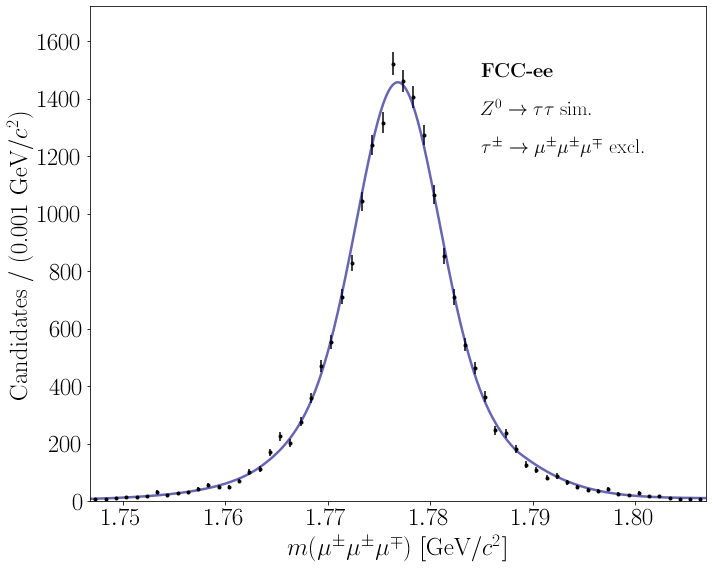

In [67]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.001
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(\mu^\pm \mu^\pm \mu^\mp)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(1.785,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(1.785,0.82*ymax,"$Z^0 \\to \\tau \\tau$ sim.",fontsize=20)
plt.text(1.785,0.74*ymax,"$\\tau^\pm \\to \mu^\pm \mu^\pm \mu^\mp$ excl.",fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_Tau_M_fit.pdf")

In [68]:
#Number of Z's produced per year (4) per experiment (2)
N_Z = 3e12 * 0.25 * 0.5
#Number of taus produced
N_tau = 2 * 0.0337 * N_Z
#Number of tau -> 3mu
N_3Mu = N_tau * 2.1e-8

print("N expected per year per exp = %.3e" % N_3Mu)

N expected per year per exp = 5.308e+02
